# **Birds 525 Species Image Classification**

This dataset contains 525 birds image, with 84,635 training images and 2625 test images and 2625 validation images (5 Images per species). You can download the dataset from [Kaggle](https://www.kaggle.com/datasets/gpiosenka/100-bird-species).
In this notebook, I will use Neural Networks to classify the images using Keras.  The dataset must be downloaded and extracted to the same directory as this notebook in a folder named `birds`.

Neccesary Libraries:

In [1]:
import pandas as pd
import numpy as np
import os

from tensorflow.keras.utils import load_img

from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dropout, Dense



import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

# **Exploratory Data Analysis (EDA) and Splitting the Data**

Load the dataset and explore the data.

In [2]:
base_path = 'birds/'

# Loading the data
birds_df = pd.read_csv(base_path + 'birds.csv')

# Updating the filepaths
birds_df['filepaths'] = base_path + birds_df['filepaths']

The dataset has a error in the csv file, the specie Paraket Auklet is referenced as Parakeet Akulet in the path of the images. I will modify the folder name to match the csv file.

In [3]:
# Renaming the folder

if not os.path.exists(base_path + 'train/PARAKETT  AKULET'):
    os.rename(base_path + 'train/PARAKETT  AUKLET', base_path + 'train/PARAKETT  AKULET')

if not os.path.exists(base_path + 'test/PARAKETT  AKULET'):
    os.rename(base_path + 'test/PARAKETT  AUKLET', base_path + 'test/PARAKETT  AKULET')

if not os.path.exists(base_path + 'valid/PARAKETT  AKULET'):
    os.rename(base_path + 'valid/PARAKETT AUKLET', base_path + 'valid/PARAKETT  AKULET')


For the purpose of this notebook, I will use only 10 species of birds.

In [4]:
num_classes = 30

most_represented_birds = birds_df['labels'].value_counts().index[:num_classes]

birds_df = birds_df[birds_df['labels'].isin(most_represented_birds)]


class_mapping = {label: idx for idx, label in enumerate(most_represented_birds)}

birds_df['class id'] = birds_df['labels'].map(class_mapping)


Columns:

In [5]:
birds_df.columns

Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')

Number of images in the dataset:

In [6]:
birds_df.shape

(6639, 5)

Number of images in the for each species:

In [7]:
birds_df['scientific name'].value_counts().head(5)

scientific name
DENDROCITTA VAGABUNDA     273
HAEMORHOUS MEXICANUS      258
TRACHYPHONUS DARNAUDII    243
SEIURUS AUROCAPILLA       243
MEROPS ORIENTALIS         230
Name: count, dtype: int64

Get class names and its corresponding number representation:

In [8]:
# Get class names and its corresponding number representation:

classes = birds_df.groupby('class id')['scientific name'].unique()

Split the data into training, validation and test sets:

In [9]:
import random


r_classes = random.choices(classes.index, k=4)
r_classes


[9, 14, 29, 29]

Image example:

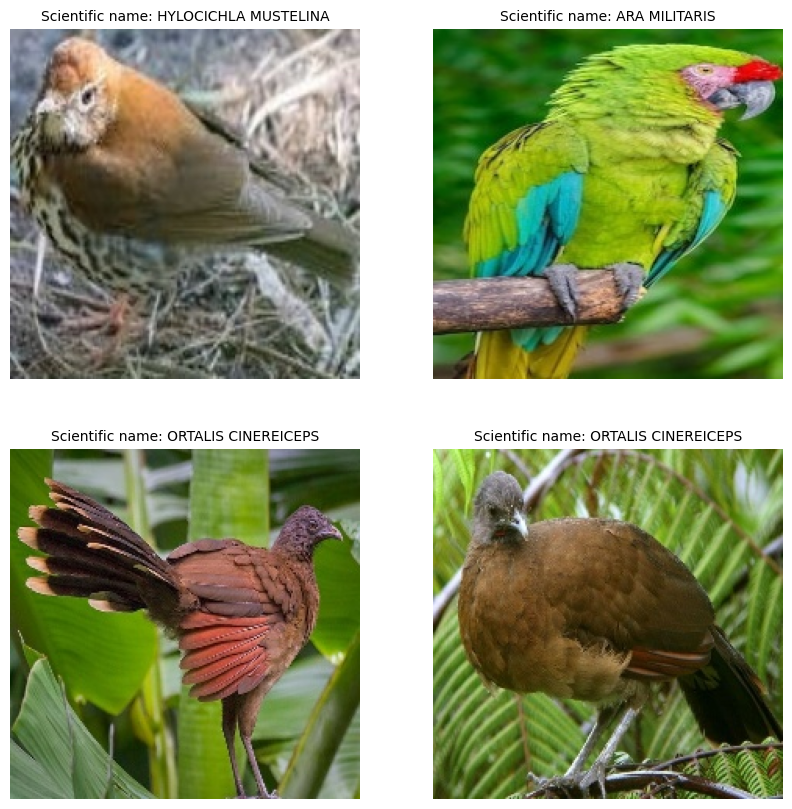

In [10]:

index = 0
plt.figure(figsize=(10, 10))
for c in r_classes:
    row = birds_df[birds_df['class id'] == c].sample(1).iloc[0]
    ax = plt.subplot(2, 2, index + 1)
    img = mpimg.imread(row['filepaths'])
    ax.imshow(img)
    ax.axis('off')

    ax.set_title(f"Scientific name: {row['scientific name']}", fontsize=10)
    index += 1




In [11]:
train_df = birds_df[birds_df['data set'] == 'train']
val_df = birds_df[birds_df['data set'] == 'valid']
test_df = birds_df[birds_df['data set'] == 'test']


In [12]:
train_df.shape, val_df.shape, test_df.shape

((6339, 5), (150, 5), (150, 5))

In [13]:
train_df['class id'].value_counts().head(5)

class id
0    263
1    248
2    233
3    233
4    220
Name: count, dtype: int64

# **Building the Model**

### *Data Preprocessing*

In [14]:
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [15]:
# Load and preprocess the images of df
def load_and_preprocess_images(df):
    data = []
    labels = []

    for index, row in df.iterrows():

        img = load_img(row['filepaths'], target_size=(64, 64))

        img_array = img_to_array(img)

        data.append(img_array)
        labels.append(row['class id'])

    return np.array(data), np.array(labels)


X_train, y_train = load_and_preprocess_images(train_df)
X_val, y_val = load_and_preprocess_images(val_df)
X_test, y_test = load_and_preprocess_images(test_df)


Example of the images after resizing:

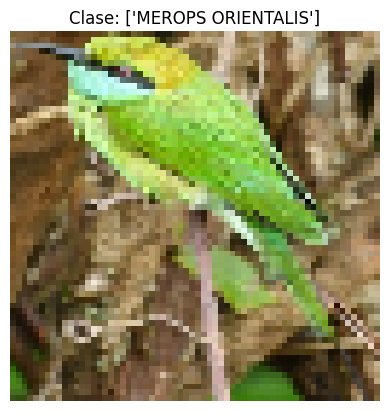

Clase: ['MEROPS ORIENTALIS']


In [16]:
index = 1

imagen = X_val[index].astype(int) 

# Mostrar la imagen
plt.imshow(imagen)
plt.title(f"Clase: {classes[y_val[index]]}")
plt.axis('off')  
plt.show()
print(f"Clase: {classes[y_val[index]]}")

In [17]:
# Normalize the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [18]:
input_shape = X_val[0].shape

def create_baseline_model(num_classes=200, learning_rate=0.001, input_shape=(224, 224, 3)):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


v1_model_path = 'models/birds_classification_v1.pkl'
v1_history_path = 'models/birds_classification_v1_history.pkl'

if os.path.exists(v1_model_path):
    print('Loading model...')
    model = pickle.load(open(v1_model_path, 'rb'))
    history = pickle.load(open(v1_history_path, 'rb'))

else:
    model = create_baseline_model(num_classes=num_classes, learning_rate=0.001, input_shape=input_shape)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)
    pickle.dump(model, open(v1_model_path, 'wb'))
    pickle.dump(history, open(v1_history_path, 'wb'))


Epoch 1/40


c:\Users\peraf\Vs Code\artificial-intelligence\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0837 - loss: 4.8771 - val_accuracy: 0.1000 - val_loss: 4.3807
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2248 - loss: 3.3579 - val_accuracy: 0.1400 - val_loss: 3.7838
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3159 - loss: 2.7691 - val_accuracy: 0.1267 - val_loss: 4.5587
Epoch 4/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3538 - loss: 2.7377 - val_accuracy: 0.2000 - val_loss: 4.2070
Epoch 5/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3980 - loss: 2.5727 - val_accuracy: 0.2267 - val_loss: 3.4054
Epoch 6/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4379 - loss: 2.3210 - val_accuracy: 0.1133 - val_loss: 5.1646
Epoch 7/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4353 - loss: 2.4749 - val_accuracy: 0.1867 - val_loss: 3.8786
Epoch 8/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 2.0620 - val_accuracy: 0.0933 - val_

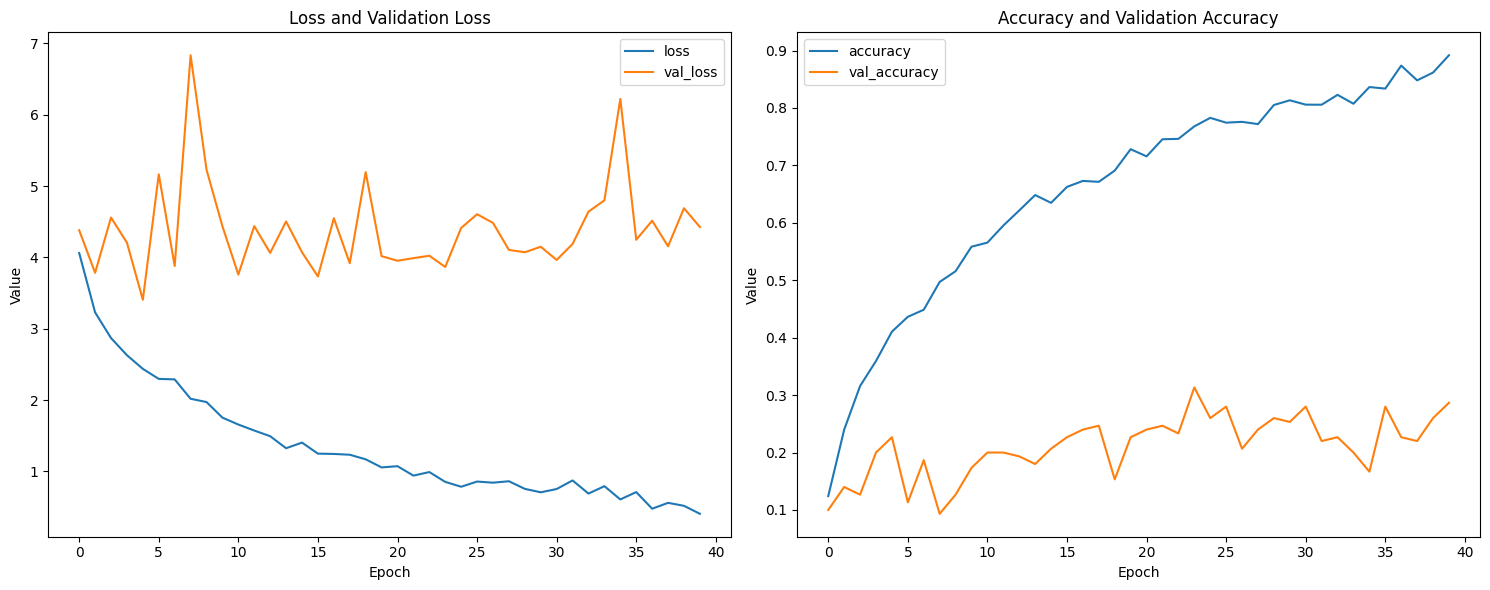

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_title('Loss and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.set_title('Accuracy and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Accuracy of the model in the training and validation sets:

In [20]:
scores = model.evaluate(X_train, y_train)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_val, y_val)
print("Val Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.8910 - loss: 0.4663
Train Accuracy: 86.94%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.2848 - loss: 4.3039
Val Accuracy: 28.67%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3920 - loss: 3.6926 
Test Accuracy: 39.33%


Testin the model with image from internet:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Text(0.5, 1.0, "['PHAETHON AETHEREU'] - 0.881449282169342")

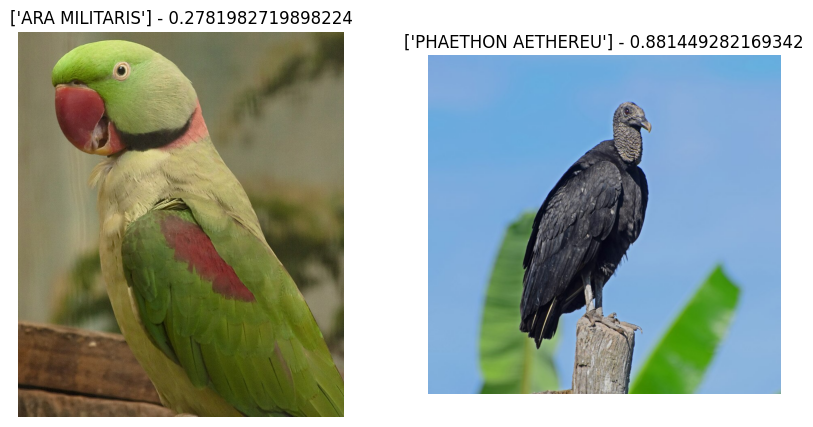

In [21]:
TEST_1 = 'birds/test_1.jpg'
TEST_2 = 'birds/test_2.jpg'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

img_1 = preprocess_image(TEST_1, target_size=(64, 64))

ax1.imshow(mpimg.imread(TEST_1))
ax1.axis('off')

pred_1 = model.predict(img_1)
ax1.set_title(f"{classes[np.argmax(pred_1)]} - {np.max(pred_1)}")


img_2 = preprocess_image(TEST_2, target_size=(64, 64))

ax2.imshow(mpimg.imread(TEST_2))
ax2.axis('off')

pred_2 = model.predict(img_2)
ax2.set_title(f"{classes[np.argmax(pred_2)]} - {np.max(pred_2)}")

### *Reducing Overfitting*


From the metrics we can see that the model is overfitting. Because we can see that the accuracy in the training set is much higher than the accuracy in the validation set, and the validation loss is higher than the training loss and for each new it is increasing. To reduce overfitting, I will modify my base model by adding Dropout layers and regularization.

In [22]:
# Import dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2



def create_baseline_modified_model(num_classes=200, learning_rate=0.001, input_shape=(224, 224, 3)):
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


v2_model_path = 'models/birds_classification_v2.pkl'
v2_history_path = 'models/birds_classification_v2_history.pkl'



if os.path.exists(v2_model_path):
    model_v2 = pickle.load(open(v2_model_path, 'rb'))
    history_v2 = pickle.load(open(v2_history_path, 'rb'))

else:
    model_v2 = create_baseline_modified_model(num_classes=num_classes, learning_rate=0.001, input_shape=input_shape)
    history_v2 = model_v2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)
    pickle.dump(model_v2, open(v2_model_path, 'wb'))
    pickle.dump(history_v2, open(v2_history_path, 'wb'))

Epoch 1/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.0457 - loss: 4.0787 - val_accuracy: 0.0800 - val_loss: 3.3486
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0900 - loss: 3.2668 - val_accuracy: 0.1467 - val_loss: 3.1713
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.1413 - loss: 3.0210 - val_accuracy: 0.1800 - val_loss: 3.0107
Epoch 4/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.1917 - loss: 2.8581 - val_accuracy: 0.1800 - val_loss: 3.0227
Epoch 5/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2381 - loss: 2.6464 - val_accuracy: 0.2000 - val_loss: 3.0511
Epoch 6/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2671 - loss: 2.5525 - val_accuracy: 0.2133 - val_loss: 2.9748
Epoch 7/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2966 - loss: 2.4436 - val_accuracy: 0.2733 - val_loss: 2.7974
Epoch 8/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3303 - loss: 2.3065 - val_accu

In [23]:
scores = model_v2.evaluate(X_train, y_train)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

scores = model_v2.evaluate(X_val, y_val)
print("Val Accuracy: %.2f%%" % (scores[1]*100))

scores = model_v2.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8032 - loss: 0.6818
Train Accuracy: 78.66%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3481 - loss: 3.8214 
Val Accuracy: 33.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4110 - loss: 2.7053 
Test Accuracy: 38.67%


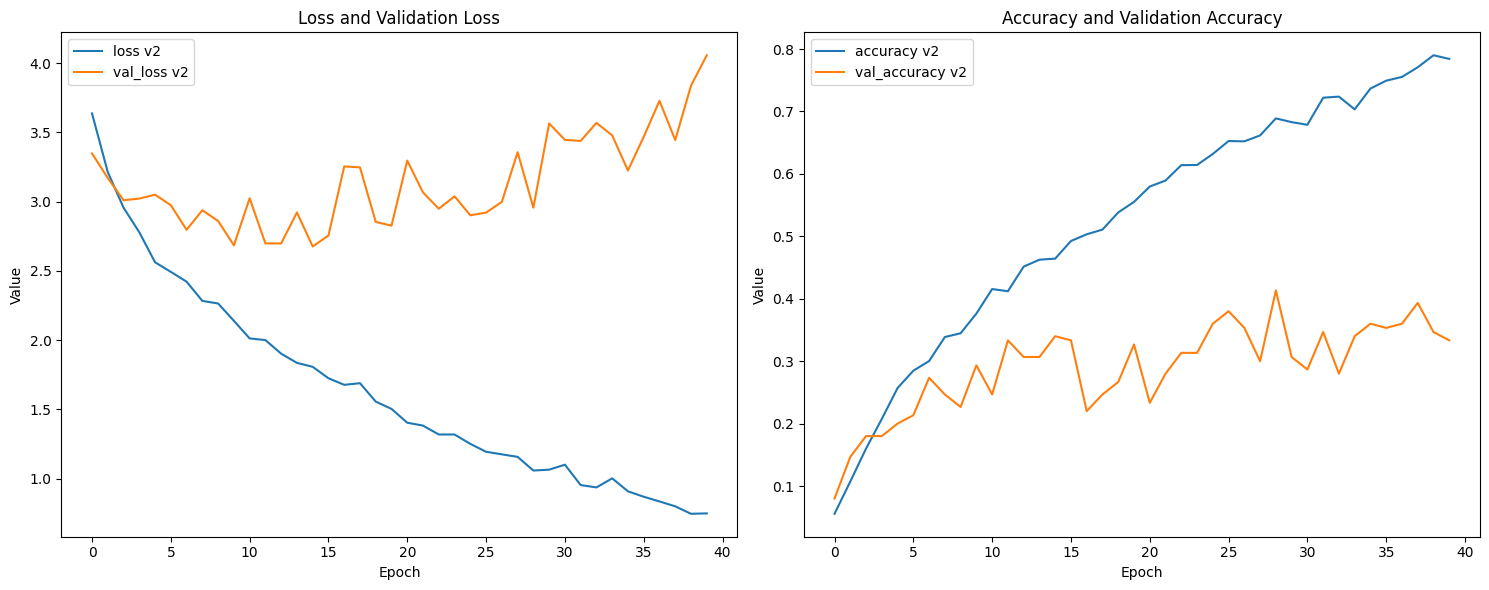

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(history_v2.history['loss'], label='loss v2')
ax1.plot(history_v2.history['val_loss'], label='val_loss v2')
ax1.set_title('Loss and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(history_v2.history['accuracy'], label='accuracy v2')
ax2.plot(history_v2.history['val_accuracy'], label='val_accuracy v2')
ax2.set_title('Accuracy and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### *Bayesian Hyperparameter Optimization*

I will use the Bayesian Optimization to find the best hyperparameters for the model.

In [25]:
import keras_tuner as kt


def create_tuner_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(64, 64, 3)))

    # Add dense layers, varying the number of units
    model.add(Dense(
        units = hp.Int('units_layer_1', min_value=128, max_value=512, step=32),
        activation='relu'
    ))

    model.add(Dense(
        units = hp.Int('units_layer_2', min_value=64, max_value=256, step=32),
        activation='relu'
    ))

    model.add(Dense(
        units = hp.Int('units_layer_3', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))
    ))

    model.add(Dense(40, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


tuner = kt.BayesianOptimization(
    create_tuner_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner',
    project_name='birds_classification'
)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


tuned_model_path = 'models/birds_classification_tuned.pkl'
tuned_history_path = 'models/birds_classification_tuned_history.pkl'

if os.path.exists(tuned_model_path):
    model_tuner = pickle.load(open(tuned_model_path, 'rb'))
    history_tuner = pickle.load(open(tuned_history_path, 'rb'))
else:
    model_tuner = tuner.hypermodel.build(best_hps)
    history_tuner = model_tuner.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
    pickle.dump(model_tuner, open(tuned_model_path, 'wb'))
    pickle.dump(history_tuner, open(tuned_history_path, 'wb'))


Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.03333333507180214

Best val_accuracy So Far: 0.31333333253860474
Total elapsed time: 00h 09m 17s
Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.0510 - loss: 3.5752 - val_accuracy: 0.0667 - val_loss: 3.3842
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1106 - loss: 3.2330 - val_accuracy: 0.1200 - val_loss: 3.1337
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1691 - loss: 3.0028 - val_accuracy: 0.2067 - val_loss: 3.0259
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2219 - loss: 2.8202 - val_accuracy: 0.2667 - val_loss: 2.8892
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2717 - loss: 2.6526 - val_accuracy: 0.2467 - val_loss: 2.8456
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3096 - loss: 2.5133 - val_accuracy: 0.2533 - val_loss: 2.8516
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3269 - loss: 2

In [26]:
scores = model_tuner.evaluate(X_train, y_train)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

scores = model_tuner.evaluate(X_val, y_val)
print("Val Accuracy: %.2f%%" % (scores[1]*100))

scores = model_tuner.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5613 - loss: 1.5066
Train Accuracy: 56.63%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2665 - loss: 2.5815 
Val Accuracy: 28.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3778 - loss: 2.1888 
Test Accuracy: 35.33%


In [27]:
model_tuner.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        98,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,260,986 (73.47 MB)

 Trainable params: 6,420,328 (24.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,840,658 (48.98 MB)

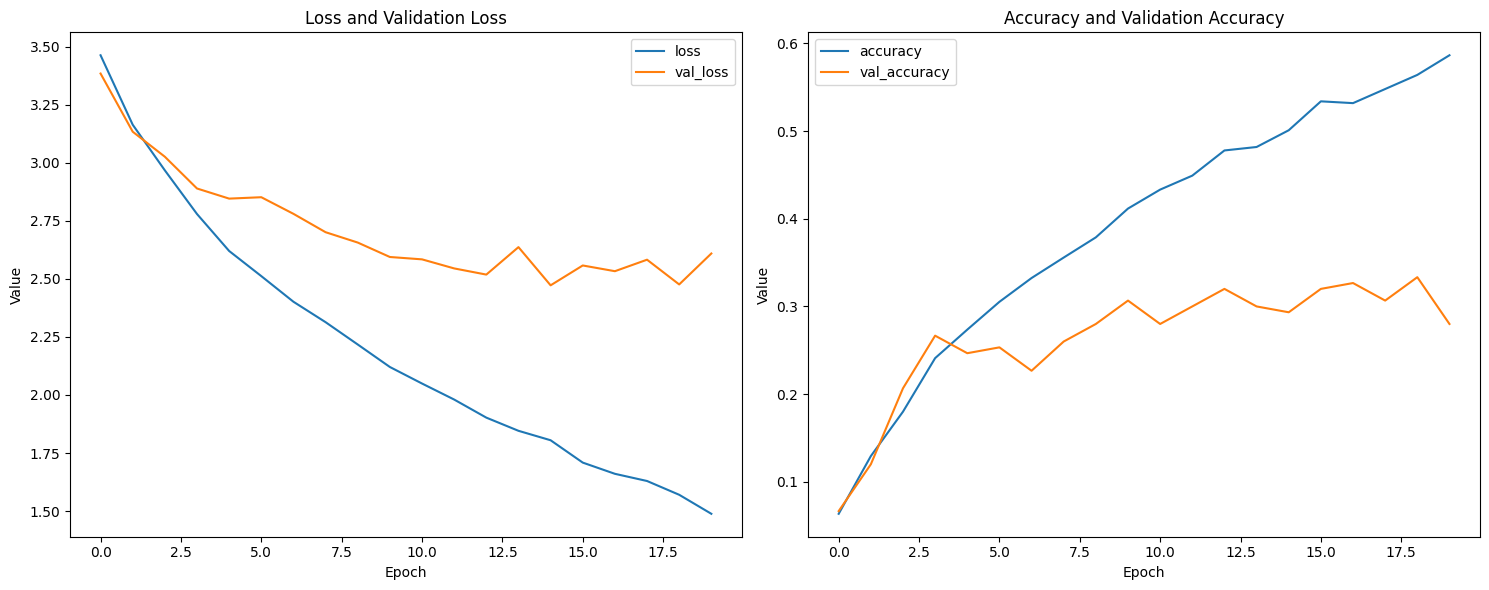

In [28]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(history_tuner.history['loss'], label='loss')
ax1.plot(history_tuner.history['val_loss'], label='val_loss')
ax1.set_title('Loss and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(history_tuner.history['accuracy'], label='accuracy')
ax2.plot(history_tuner.history['val_accuracy'], label='val_accuracy')
ax2.set_title('Accuracy and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### *Model with More Complex Architecture*

I will use a more complex architecture with convolutional layers and pooling layers. These layers will help the model to learn more complex patterns in the images.

In [29]:
def create_complex_model(num_classes, learning_rate, input_shape):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    

    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

v_3_model_path = 'models/birds_classification_v3.pkl'
v_3_history_path = 'models/birds_classification_v3_history.pkl'

if os.path.exists(v_3_model_path):
    model_v3 = pickle.load(open(v_3_model_path, 'rb'))
    history_v3 = pickle.load(open(v_3_history_path, 'rb'))
else:
    model_v3 = create_complex_model(num_classes=num_classes, learning_rate=0.001, input_shape=input_shape)
    history_v3 = model_v3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
    pickle.dump(model_v3, open(v_3_model_path, 'wb'))
    pickle.dump(history_v3, open(v_3_history_path, 'wb'))

Epoch 1/20


c:\Users\peraf\Vs Code\artificial-intelligence\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.2626 - loss: 3.6435 - val_accuracy: 0.1000 - val_loss: 6.7646
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6250 - loss: 1.2525 - val_accuracy: 0.2067 - val_loss: 4.4246
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8082 - loss: 0.6450 - val_accuracy: 0.5067 - val_loss: 2.0890
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9093 - loss: 0.2950 - val_accuracy: 0.5600 - val_loss: 1.9413
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9535 - loss: 0.1495 - val_accuracy: 0.5800 - val_loss: 2.0968
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9691 - loss: 0.0987 - val_accuracy: 0.6400 - val_loss: 2.1330
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9808 - loss: 0.0614 - val_accuracy: 0.5067 - val_loss: 2.9451
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9411 - loss: 0.2041 - val_accuracy: 0.560

In [30]:
scores = model_v3.evaluate(X_train, y_train)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

scores = model_v3.evaluate(X_val, y_val)
print("Val Accuracy: %.2f%%" % (scores[1]*100))

scores = model_v3.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9434 - loss: 0.2860
Train Accuracy: 94.59%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5163 - loss: 4.7465 
Val Accuracy: 52.67%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6731 - loss: 3.4127 
Test Accuracy: 66.00%


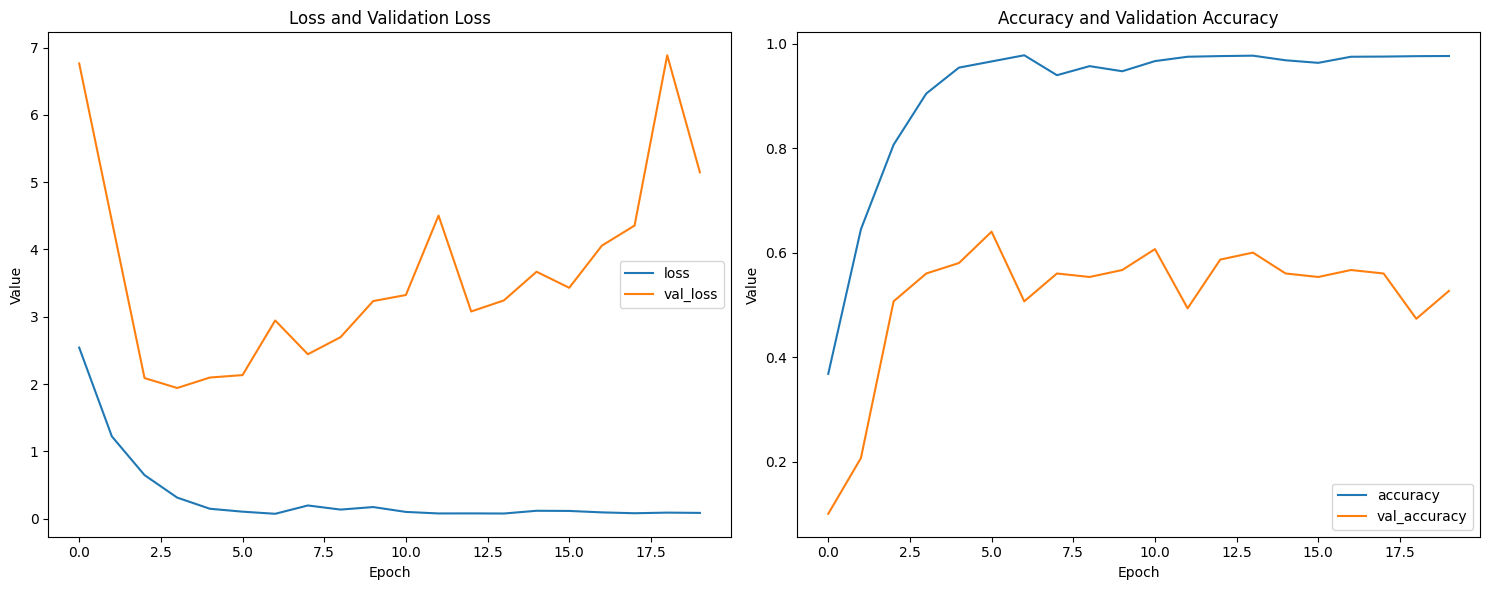

In [31]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(history_v3.history['loss'], label='loss')
ax1.plot(history_v3.history['val_loss'], label='val_loss')
ax1.set_title('Loss and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(history_v3.history['accuracy'], label='accuracy')
ax2.plot(history_v3.history['val_accuracy'], label='val_accuracy')
ax2.set_title('Accuracy and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()